In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
class ParametersSamples:
    def __init__(self, number, mean, sd):
        self.number = number
        self.mean = mean
        self.sd = sd

In [186]:
class GetData:
    PERCENT_LABELED = 0.2
    param1 = ParametersSamples(1000, 0, 4)
    param2 = ParametersSamples(1000, 6, 2)
    
    def _get_data1(self):
        param = self.param1
        X1 = scipy.stats.norm.rvs(param.mean, param.sd, size=(param.number, 2))
        y1 = np.ones((param.number, 1))
        labeled1 = np.random.binomial(1, self.PERCENT_LABELED, (param.number, 1))
        data1 = np.hstack([X1, y1, labeled1])
        return data1
    
    def _get_data2(self):
        param = self.param2
        X1 = scipy.stats.norm.rvs(param.mean, param.sd, size=(param.number, 2))
        y1 = np.zeros((param.number, 1))
        labeled1 = np.zeros((param.number, 1))
        data1 = np.hstack([X1, y1, labeled1])
        return data1
    
    def get_data(self):              
        columns = ['x1', 'x2', 'y', 's']
        data1 = self._get_data1()
        data2 = self._get_data2()
        data3 = data1[data1[:, 3] == 1, : ]
        plt.title("data")
        plt.plot(data1[:, 0], data1[:, 1], 'r+')
        plt.plot(data2[:, 0], data2[:, 1], 'bo')
        plt.plot(data3[:, 0], data3[:, 1], 'go')
        plt.legend(['y = 1', 'y = 0', 'y = 1 and s = 1'])
        
        return pd.DataFrame(np.vstack([data1, data2]), columns=columns)
        

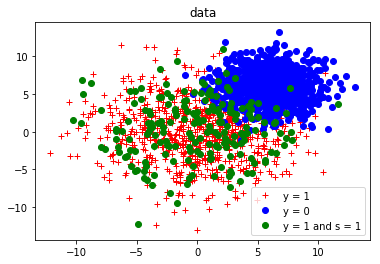

In [187]:
data = GetData().get_data()

In [188]:
train, test = train_test_split(data, train_size = 0.8)

In [189]:
model_svc = SVC(class_weight='balanced', kernel='poly', gamma='scale', probability=True)

model_svc = model_svc.fit(train.loc[:,['x1', 'x2']], train.loc[:, 's'])


In [190]:
model_svc.score(train.loc[:, ['x1', 'x2']], train.loc[:, 'y'])

0.91125

In [191]:
model_svc.score(test.loc[:, ['x1', 'x2']], test.loc[:, 'y'])

0.91

In [192]:
class ClassifierOnlyPositiveAndUnlabeledData:
    
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        train_X, validate_X, train_y, validate_y = train_test_split(X, y, train_size=0.9)
        self._model = SVC(class_weight='balanced', kernel='poly', gamma='scale', probability=True)
        self._model.fit(train_X, train_y)
        self._foo(validate_X, validate_y)
        
    # get estimate of p(s = 1 | y = 1) 
    def _foo(self, X, y):
        X_true = X[y == 1]
        probabilities = self._base_model_predict_proba(X_true)
        self._coef = sum(probabilities) / X_true.shape[0]
        
    def predict_proba(self, X):
        return self._base_model_predict_proba(X) / self._coef
    
    def predict(self, X):
        return np.apply_along_axis(lambda x: 1 if x >= 0.5 else 0, 1, self.predict_proba(X).reshape(-1, 1))
    
    def _base_model_predict_proba(self, X):
        return self._model.predict_proba(X)[:, 1]
    
    def score(self, X, y):
        return accuracy_score(self.predict(X), y)

In [193]:
model_unlabeled_data = ClassifierOnlyPositiveAndUnlabeledData()

model_unlabeled_data.fit(train.loc[:,['x1', 'x2']], train.loc[:, 's'])

In [194]:
model_unlabeled_data.score(train.loc[:,['x1', 'x2']], train.loc[:, 'y'])

0.924375

In [195]:
model_unlabeled_data.score(test.loc[:,['x1', 'x2']], test.loc[:, 'y'])

0.94